# 영화 추천시스템 알고리즘



In [1]:
# 필수 라이브러리 import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pandas_datareader as pdr
from datetime import date
import re

In [2]:
# 그림 예쁘게
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('font', size=16)
plt.rc('legend', fontsize=16) 

# 한글 폰트 문제
plt.rcParams['axes.unicode_minus'] = False

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(14,8)})

In [3]:
# 한글 표기 문제 해결
!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

from plotnine import *
import plotnine

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

In [4]:
!pip3 install konlpy
from konlpy.tag import Okt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# 파일 불러오기(7740개의 영화 줄거리)
df = pd.read_csv('/content/drive/MyDrive/recommend_system/data.csv')
df_target = df.copy()
df_target.tail(10)


,id,title,overview
7730,878962,내 친구 샤크독: 파닥파닥 판타스틱 핼러윈,사탕 안주면 장난칠 거야! 핼러윈을 준비하며 잔뜩 신이 난 맥스. 이웃집을 돌기 전...
7731,883648,리틀 빅 마우스,밴드에서 쫓겨나 떠돌이가 된 기타리스트. 우여곡절 끝에 싱글 맘의 집에서 신세를 진...
7732,885110,아미나: 전사의 이름,지금은 나이지리아의 자리아라 불리는 곳. 16세기 자자우에서 공주 아미나가 왕국을 ...
7733,887645,완벽에서 살짝 모자란,"이혼한 변호사 이바나, 카리스마 넘치는 심장 전문의와 사랑에 빠진다. 그런데 남자의..."
7734,888910,사서함 1142: 미국의 비밀 나치 수용소,2차대전 참전 군인들의 증언을 통해 미국 내 비밀 군부대의 정체를 파헤친 단편 애니...
7735,888917,사기의 제왕,그들에게 탄소는 황금보다 빛났다. 오염물질 배출권 거래 제도를 이용해 막대한 돈을 ...
7736,889300,러브 미 인스테드,"딸과 재회하고 비로소 화해하고 싶은 죄수. 교도관과 함께 고향으로 여행을 떠나지만,..."
7737,892342,행복이여 영원하라,《Happiness is a Four-Letter Word》가 속편으로 돌아왔다. ...
7738,895571,당신은 학생인가,왜 우리가 하는 공부는 고통스러울까? 질문에 답변하기 위해 갓 수능을 마친 학생들이...
7739,897429,All Too Well: The Short Film,테일러 스위프트의 정규 6집 재녹음 앨범 Red의 수록곡 All Too Well의 ...


In [6]:
print(df_target.isnull().sum())

id          0
title       0
overview    0
dtype: int64


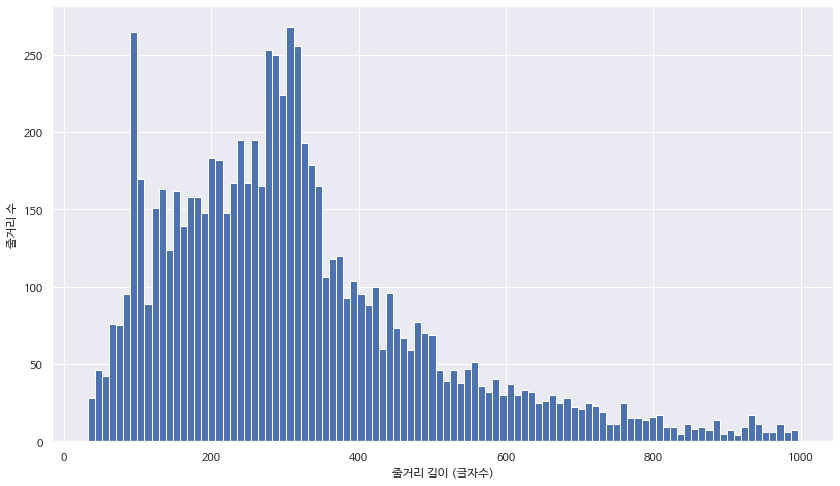

count    7740.000000
mean      315.844961
std       182.069410
min        32.000000
25%       186.000000
50%       287.000000
75%       396.250000
max       996.000000
Name: overview, dtype: float64


In [7]:
# 줄거리 길이 분포 확인

overview_length = df_target.overview.astype(str).apply(len)

plt.hist(overview_length, bins=100)
plt.xlabel('줄거리 길이 (글자수)')
plt.ylabel('줄거리 수')

plt.show()

print(overview_length.describe())

In [8]:
# 정규 표현식 적용(한글, 숫자, 영어 빼고 전부 제거)
def sub_ex(s):
  return re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]','',s)

# def sub_ex(s):
#   return re.sub(r'[^0-9a-zA-Z ]','',s)

df_target.loc[:,'overview'] = df_target.loc[:,'overview'].apply(sub_ex)

df_target.tail(10)

,id,title,overview
7730,878962,내 친구 샤크독: 파닥파닥 판타스틱 핼러윈,사탕 안주면 장난칠 거야 핼러윈을 준비하며 잔뜩 신이 난 맥스 이웃집을 돌기 전에 ...
7731,883648,리틀 빅 마우스,밴드에서 쫓겨나 떠돌이가 된 기타리스트 우여곡절 끝에 싱글 맘의 집에서 신세를 진다...
7732,885110,아미나: 전사의 이름,지금은 나이지리아의 자리아라 불리는 곳 16세기 자자우에서 공주 아미나가 왕국을 지...
7733,887645,완벽에서 살짝 모자란,이혼한 변호사 이바나 카리스마 넘치는 심장 전문의와 사랑에 빠진다 그런데 남자의 키...
7734,888910,사서함 1142: 미국의 비밀 나치 수용소,2차대전 참전 군인들의 증언을 통해 미국 내 비밀 군부대의 정체를 파헤친 단편 애니...
7735,888917,사기의 제왕,그들에게 탄소는 황금보다 빛났다 오염물질 배출권 거래 제도를 이용해 막대한 돈을 챙...
7736,889300,러브 미 인스테드,딸과 재회하고 비로소 화해하고 싶은 죄수 교도관과 함께 고향으로 여행을 떠나지만 비...
7737,892342,행복이여 영원하라,Happiness is a FourLetter Word가 속편으로 돌아왔다 자자 프...
7738,895571,당신은 학생인가,왜 우리가 하는 공부는 고통스러울까 질문에 답변하기 위해 갓 수능을 마친 학생들이 ...
7739,897429,All Too Well: The Short Film,테일러 스위프트의 정규 6집 재녹음 앨범 Red의 수록곡 All Too Well의 ...


In [9]:
# 불용어 리스트
STOP_WORDS = {'영화', '이야기', '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'}

# 형태소 분석
okt = Okt()
def morph_and_stopword(s):
  token_lst = []
  tmp = okt.morphs(s, stem=True)

  #불용어 처리
  for token in tmp:
    if token not in STOP_WORDS:
      token_lst.append(token)
  return token_lst


In [10]:
df_target.loc[:,'overview'].apply(morph_and_stopword)

0       [주인공, 카스, 리넨, 광부, 다, 일, 탄광, 폐광, 되다, 도산, 을, 사장,...
1       [새해, 전날, 밤, LA, 몽시뇰, 호텔, 에서, 첫, 근무, 되다, 괴짜, 벨,...
2       [공화국, 붕괴하다, 제국, 수립, 되다, 뒤, 20년, 제다이, 기사단, 전멸, ...
3       [광대, 어, 말리다, 아내, 코랄, 2, 세, 부화, 기다리다, 중, 상어, 습격...
4       [불편하다, 다리, 남, 보다, 조금, 떨어지다, 지능, 을, 가지다, 포레스트, ...
                              ...                        
7735    [그, 에게, 탄소, 황금, 보다, 빛나다, 오염, 물질, 배출, 권, 거래, 제도...
7736    [딸, 재회, 하고, 비로소, 화해, 하고, 싶다, 죄수, 교도관, 함께, 고향, ...
7737    [Happiness, is, a, FourLetter, Word, 가다, 속편, 돌...
7738    [왜, 우리, 공부, 고통스럽다, 질문, 답변, 위해, 갓, 수능, 을, 마치다, ...
7739    [테일러, 스위프트, 정규, 6, 집, 재녹음, 앨범, Red, 수록, 곡, All...
Name: overview, Length: 7740, dtype: object

### TF-IDF (Term Frequency-Inverse Document Frequency)

- 어떤 문서가 특정 주제를 다룰 경우 해당 주제와 관련된 단어 또는 단어의 조합이 자주 등장함 $\rightarrow$ TF (Term Frequency)
- 빈도가 높은 단어라도 모든 문서에 흔히 등장하는 경우 낮은 가중치를 부여 $\rightarrow$ IDF (Inverse Term Frequency)
- 예: 경제와 관련된 문헌의 경우 '경제'란 용어가 공통적으로 많이 등장하므로 출현 빈도에 비해 중요도를 낮게 책정
- TF-IDF 산식:
\begin{equation}
f(\log(\frac{N}{n}) + 1)
\end{equation}

  - f = 특정 단어가 어떤 문서 D에서 출현한 회수
  - N = 문서의 총 개수
  - n = N건의 문서 중 특정 단어가 출현한 회수

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 생성
tfidf = TfidfVectorizer(analyzer='word', tokenizer=morph_and_stopword)
tfidf_matrix = tfidf.fit_transform(df.overview)

# 줄거리에 대해서 tf-idf 수행
print(tfidf_matrix.shape)

(7740, 33595)


In [12]:
tfidf.get_feature_names_out()[20000:20200]

array(['아키라', '아키타견', '아키히토', '아킨', '아킨슨', '아킬', '아킴', '아킴는', '아타리',
       '아테나', '아테네', '아토스', '아톰', '아트', '아트디렉터', '아트레유', '아트리', '아트워크',
       '아틀라스', '아틀란티스', '아틀란틱', '아티', '아티스트', '아틸리오', '아파르트헤이트', '아파치',
       '아파토사우루스', '아파트', '아편', '아포', '아포칼립스', '아폴로', '아프가니스탄', '아프간',
       '아프다', '아프리카', '아프리카인', '아픔', '아합', '아호', '아홉', '아화', '아흐메드',
       '아흐바흐', '아흔', '악', '악감', '악귀', '악기', '악날', '악녀', '악단', '악담', '악당',
       '악대', '악덕', '악독', '악독하다', '악동', '악랄하다', '악령', '악마', '악명', '악몽',
       '악물다', '악바리', '악보', '악사', '악상', '악생', '악성', '악세다', '악수', '악어',
       '악역', '악연', '악용', '악운', '악의', '악인', '악재', '악전', '악조건', '악질',
       '악착같이', '악천후', '악취', '악평', '악하다', '악한', '악행', '악화', '악화시키다', '안',
       '안간힘', '안개', '안건', '안경', '안고', '안과', '안구', '안기다', '안기부', '안나',
       '안내', '안내서', '안녕', '안농', '안느', '안다', '안달', '안달루시아', '안대', '안데르센',
       '안데르손', '안데스', '안도', '안동', '안되다', '안드레', '안드레아', '안드레아스', '안드레이',
       '안드로', '안드로메다', '안드로이드', '안드르송', '안락사', '안락하다', '안마', '안면', '안목',
   

**코사인 유사도(Cosine Similarity)**

- 코사인 유사도는 거리는 보지 않고, 두 벡터의 방향만 측정함.
- 같은 방향이면 1, 정반대 방향이면 -1, 서로 독립적이라면 0이 나옴. 

\begin{equation}
similarity(A,B) = cos(\theta)=\frac{A \cdot B}{\parallel A \parallel \parallel B \parallel} = \frac{\Sigma_{i=1}^{n}a_{i}b_{i}}{\sqrt{\Sigma_{i=1}^{n}a_{i}^{2}}\sqrt{\Sigma_{i=1}^{n}b_{i}^{2}}}
\end{equation}

In [13]:
from sklearn.metrics.pairwise import linear_kernel
cosine_result = linear_kernel(tfidf_matrix, tfidf_matrix)

In [14]:
cosine_result

array([[1.        , 0.03370198, 0.02187411, ..., 0.03441463, 0.03300793,
        0.01007605],
       [0.03370198, 1.        , 0.01373494, ..., 0.01767361, 0.01526776,
        0.00237838],
       [0.02187411, 0.01373494, 1.        , ..., 0.05758804, 0.00723841,
        0.00112842],
       ...,
       [0.03441463, 0.01767361, 0.05758804, ..., 1.        , 0.02218411,
        0.0022489 ],
       [0.03300793, 0.01526776, 0.00723841, ..., 0.02218411, 1.        ,
        0.00291445],
       [0.01007605, 0.00237838, 0.00112842, ..., 0.0022489 , 0.00291445,
        1.        ]])

In [15]:
indices_title = pd.Series(df.index, index=df.title).drop_duplicates()
print(indices_title)

title
아리엘                                0
포룸                                 1
스타워즈: 에피소드 4 새로운 희망                2
니모를 찾아서                            3
포레스트 검프                            4
                                ... 
사기의 제왕                          7735
러브 미 인스테드                       7736
행복이여 영원하라                       7737
당신은 학생인가                        7738
All Too Well: The Short Film    7739
Length: 7740, dtype: int64


In [16]:
def movie_rec_title(title, cosine_matrix=cosine_result):
    """
    타이틀을 입력받아 영화를 추천해줍니다.
    """

    #입력한 영화로 부터 인덱스 가져오기
    idx = indices_title[title]

    # 모든 영화에 대해서 해당 영화와의 유사도를 구하기
    rec_scores = list(enumerate(cosine_matrix[idx]))

    # 유사도에 따라 영화들을 정렬
    rec_scores = sorted(rec_scores, key=lambda x:x[1], reverse = True)

    # 가장 유사한 10개의 영화를 받아옴
    rec_scores = rec_scores[1:11]

    # 가장 유사한 10개 영화의 인덱스 받아옴
    movie_indices = [i[0] for i in rec_scores]
    
    #기존에 읽어들인 데이터에서 해당 인덱스의 값들을 가져온다. 그리고 스코어 열을 추가하여 코사인 유사도도 확인할 수 있게 한다.
    result_df = df.iloc[movie_indices].copy()
    result_df['score'] = [i[1] for i in rec_scores]
    
    # 읽어들인 데이터에서 줄거리 부분만 제거, 제목과 스코어만 보이게 함
    del result_df['overview']

    # 가장 유사한 10개의 영화의 제목을 리턴
    return result_df

In [17]:
movie_rec_title('스타워즈: 에피소드 4 새로운 희망')

,id,title,score
747,1891,스타워즈: 에피소드 5 제국의 역습,0.358536
4524,140607,스타워즈: 깨어난 포스,0.302680
6181,433356,오토만 루테넌트,0.218106
748,1892,스타워즈: 에피소드 6 제다이의 귀환,0.216074
3676,39319,테일즈 오브 베스페리아 : 퍼스트 스트라이크,0.203754
5428,330459,로그 원: 스타워즈 스토리,0.173689
7409,660006,마담 클로드,0.172423
7008,565179,퍼스트 킹: 로마 전설의 시작,0.171255
1924,10196,라스트 에어벤더,0.161754
4674,181808,스타워즈: 라스트 제다이,0.151868



그렇다면 이제 우리의 db에 저장해주기 위해 id 기반으로 데이터를 생성하겠습니다.


In [18]:
indices = pd.Series(df.index, index=df.id)
print(indices)

id
2            0
5            1
11           2
12           3
13           4
          ... 
888917    7735
889300    7736
892342    7737
895571    7738
897429    7739
Length: 7740, dtype: int64


In [19]:
def movie_rec(id, cosine_matrix=cosine_result):
    """
    db에 저장하기 위해 영화의 id로부터 추천 id를 반환합니다. 
    """

    #입력한 영화로 부터 인덱스 가져오기
    idx = indices[id]

    # 모든 영화에 대해서 해당 영화와의 유사도를 구하기
    rec_scores = list(enumerate(cosine_matrix[idx]))

        
    # 유사도에 따라 영화들을 정렬
    rec_scores = sorted(rec_scores, key=lambda x:x[1], reverse = True)

    # 가장 유사한 10개의 영화를 받아옴
    rec_scores = rec_scores[1:11]

    # 가장 유사한 10개 영화의 인덱스 받아옴
    movie_indices = [i[0] for i in rec_scores]
    
    #기존에 읽어들인 데이터에서 해당 인덱스의 값들을 가져온다.
    result_df = df.iloc[movie_indices].copy()
    result_df['score'] = [i[1] for i in rec_scores]
    
    # 읽어들인 데이터에서 줄거리 부분만 제거, 제목과 스코어만 보이게 함
    del result_df['overview']
    del result_df['score']

    # 가장 유사한 10개의 영화의 제목을 리턴
    return result_df

In [20]:
movie_rec(13)

,id,title
2901,14306,말리와 나
3079,16780,텍사스 전기톱 학살 4
7589,760195,세퍼레이션
5769,376867,문라이트
6730,514439,기적의 소년
2108,10650,더티 해리 4 - 써든 임팩트
1283,7980,러블리 본즈
4389,109689,아이 원트 유
1586,9443,불의 전차
3415,26022,내 이름은 칸




json의 형태로 저장해주기 위해 딕셔너리 형태로 만들어줍니다.



In [21]:
result_dict = {}

for id in df.id:
  result_dict[id] = list(movie_rec(id).id)

print(result_dict)

{2: [257874, 625568, 234200, 82023, 265195, 12106, 1262, 2003, 121986, 10176], 5: [522681, 11888, 6145, 4547, 1649, 313922, 1944, 15582, 179538, 12192], 11: [1891, 140607, 433356, 1892, 39319, 330459, 660006, 565179, 10196, 181808], 12: [127380, 31011, 205321, 45156, 578, 1634, 8914, 86703, 59963, 505225], 13: [14306, 16780, 760195, 376867, 514439, 10650, 7980, 109689, 9443, 26022], 14: [12120, 711, 13683, 6557, 156711, 38684, 22897, 84199, 11025, 10242], 15: [9516, 32985, 9946, 400136, 11355, 8675, 60747, 40814, 336890, 891], 16: [526019, 333596, 297, 273895, 426543, 2124, 345, 8470, 1969, 522931], 18: [10196, 2164, 275619, 760873, 495193, 830, 19761, 399174, 282813, 1979], 19: [887, 240483, 2447, 59965, 9586, 9928, 17124, 526051, 2048, 454619], 20: [600354, 804, 18615, 11133, 1412, 26820, 12184, 33689, 45094, 227700], 22: [58, 1865, 285, 166426, 60293, 109424, 12311, 11085, 2669, 1989], 24: [393, 74998, 4147, 804435, 10727, 11647, 19556, 2487, 248574, 24411], 25: [405775, 4349, 9793,

In [22]:
import pickle

with open('recommendations.p', 'wb') as file:
    recommendations = pickle.dump(result_dict, file)

출처: https://blog.naver.com/PostList.naver?blogId=myincizor&from=postList&categoryNo=6